In [16]:
# importing packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from pickle import dump, load

In [17]:
df = pd.read_csv('/Users/SnehPandya/Desktop/nn/train.csv')
df2 = pd.read_csv('/Users/SnehPandya/Desktop/nn/test_zmi_pred.csv')

In [18]:
df.head()

,ID,Mass_ground_truth,u_band,g_band,r_band,i_band,z_band,z,M_i,ug,gr,ri,iz,zu
0,1641089,8.973414,18.982250,18.900643,18.596375,18.584750,18.720857,1.1875,-25.451,0.081607,0.304268,0.011625,-0.136107,-0.261393
1,2532495,8.445230,20.822754,20.706984,20.583098,20.400262,20.097541,2.0993,-25.290,0.115770,0.123885,0.182836,0.302721,-0.725213
2,1583940,8.844659,21.185649,20.891439,20.409386,20.336351,20.082965,1.1103,-23.982,0.294211,0.482053,0.073035,0.253386,-1.102684
3,2608143,8.051990,20.238111,19.877519,19.916019,19.845519,19.731352,0.6794,-23.246,0.360593,-0.038500,0.070500,0.114167,-0.506759
4,2464194,9.409361,17.895957,17.664872,17.407213,17.446128,17.437894,1.0459,-26.482,0.231085,0.257660,-0.038915,0.008234,-0.458064


In [19]:
df2.head()

,ID,Mass_ground_truth,u_band,g_band,r_band,i_band,z_band,z,M_i,ug,gr,ri,iz,zu
0,2608143,8.051990,20.238111,19.877519,19.916019,19.845519,19.731352,0.671787,-23.173836,0.360593,-0.038500,0.070500,0.114167,-0.506759
1,2464194,9.409361,17.895957,17.664872,17.407213,17.446128,17.437894,1.081344,-24.156456,0.231085,0.257660,-0.038915,0.008234,-0.458064
2,3909577,9.581839,20.311204,19.343122,19.101469,18.716061,18.463020,1.474508,-24.291647,0.968082,0.241653,0.385408,0.253041,-1.848184
3,4145278,9.441872,21.854708,21.099604,20.204875,19.870313,19.700333,1.262152,-24.616636,0.755104,0.894729,0.334562,0.169979,-2.154375
4,4055950,8.900853,20.281486,20.296457,19.910000,19.909257,19.935143,1.316529,-24.243092,-0.014971,0.386457,0.000743,-0.025886,-0.346343


In [20]:
class BHDataset(Dataset):
    def __init__(self, path, train=True):
        self.path = path
        self.train = train
        self.sc = StandardScaler()

        if self.train:
            self.data = pd.read_csv(self.path + 'train.csv')
            self.features = self.sc.fit_transform(np.asarray(self.data.iloc[:,7:]))
            dump(self.sc, open('train_scaler_reject_zmi.pkl','wb'))
        
        else:
            self.data = pd.read_csv(self.path + 'test_zmi_pred.csv')
#             self.data = self.data.drop(columns = ['Unnamed: 0'])
            self.sc = load(open('train_scaler_reject_zmi.pkl','rb'))
            self.features = self.sc.transform(np.asarray(self.data.iloc[:,7:]))
            
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):

        ID = torch.from_numpy(np.asarray(self.data.iloc[index,0]))
        mass = torch.from_numpy(np.asarray(self.data.iloc[index,1]))
        features = torch.from_numpy(self.features[index].reshape(1,-1))
        return (ID, features, mass)

        
train_ds = BHDataset('/Users/SnehPandya/Desktop/nn/')
test_ds = BHDataset('/Users/SnehPandya/Desktop/nn/', train=False) 
train_ds.__getitem__(0)

(tensor(1641089),
 tensor([[-0.5321, -0.2927, -0.6067,  0.2835, -0.9217, -1.7037,  0.8434]],
        dtype=torch.float64),
 tensor(8.9734, dtype=torch.float64))

In [21]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 64)
        self.fc7 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

net = Net()
net.load_state_dict(torch.load('/Users/SnehPandya/Desktop/nn/AGNet_100epoch.mdl'))

<All keys matched successfully>

In [23]:
# loss function and optimizer
optimizer = optim.AdamW(net.parameters(), lr=0.001)
loss_function = F.smooth_l1_loss

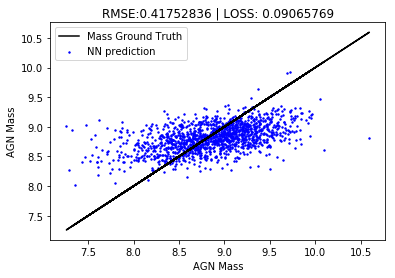

In [24]:
# testing loop
def test(net):

    with torch.no_grad():
        outputs_ID, outputs_pred, outputs_mass = ([] for i in range(3))
        
        for data in test_dl:
            ID, X, mass = data  # X is the batch of features, y is the batch of targets.
            outputs_ID.append(ID)
            outputs_mass.append(mass.float())
            output = net(X.float()) # pass in the reshaped batch (recall they are 28x28 atm)
            outputs_pred.append(output.float())
            loss = loss_function(output.squeeze(), mass.float().squeeze())# calc and grab the loss value

        ground_truth = torch.cat(outputs_mass).data # .stack for using dataset (.cat for dataloader)
        predictions = torch.cat(outputs_pred).data.flatten()
        ID = torch.cat(outputs_ID).data
        rmse = np.sqrt(metrics.mean_squared_error(ground_truth, predictions))
        plt.plot(ground_truth, ground_truth,color='black', label = 'Mass Ground Truth')
        plt.scatter(ground_truth,predictions,s=2, color='blue', label = 'NN prediction')
        plt.title('RMSE:' + str(rmse) + ' | LOSS: ' + str(loss.data.numpy()))
        plt.xlabel('AGN Mass')
        plt.ylabel('AGN Mass')
        plt.legend()
        plt.show()
        
        df = pd.DataFrame({'ID':ID.numpy(), 'ground truth':ground_truth.numpy(), 'network predictions':predictions.numpy() })
        return df
df = test(net)

In [25]:
df.to_csv('/Users/SnehPandya/Desktop/nn/mass_zmipred_results.csv')